<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Stock_Analysis/Nifty100_Buy_Sell_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Stock_Analysis/data/Nifty100Scrips.csv')

mypf = mypf[mypf['InScope'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol']

#stock_ids

stock_ids = stock_n100

In [ ]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib 
yfin.pdr_override()
import pandas_ta as ta

In [ ]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20 
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'    
    
    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = yfin.Ticker(stock_symbol).history(period='2y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)     

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    #stock_df['200_SMA_Lag10'] = stock_df['200_SMA'].shift(10)
    #stock_df['Slope%_200'] = round((stock_df['200_SMA'] - stock_df['200_SMA_Lag10'])*100/stock_df['200_SMA'],2)
    #stock_df['50_SMA_Lag5'] = stock_df['50_SMA'].shift(5)
    #stock_df['Slope%_50'] = round((stock_df['50_SMA'] - stock_df['50_SMA_Lag5'])*100/stock_df['50_SMA'],2)
    stock_df['Max'] = round(max(stock_df['Close']),0)
    stock_df['Min'] = round(min(stock_df['Close']),0)    
    #stock_df['Dev%_Max'] = round((stock_df['Close Price'] - stock_df['Max'])*100/stock_df['Max'],2)
    #stock_df['Dev%_Min'] = round((stock_df['Close Price'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df['Premium%'] = round((stock_df['Close']-stock_df['Min'])*100/(stock_df['Max']-stock_df['Min']),2)
    stock_df['Discount%'] = round((stock_df['Max']-stock_df['Close'])*100/(stock_df['Max']-stock_df['Min']),2)
    #stock_df.ta.macd(close='Close', fast=12, slow=26, append=True)
    #stock_df['Trend'] = 'Down'
    #stock_df.loc[stock_df['MACD_12_26_9'] - stock_df['MACDs_12_26_9'] > 10, 'Trend'] = 'Up'
    #stock_df.ta.eom(append=True)    
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'EOM_14_100000000':'EOM'}, inplace=True)
    stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    stock_df['Close'] = round(stock_df['Close'],0) 
    #stock_df['EOM'] = round(stock_df['EOM'],0) 
    #stock_df['EOM'] = '-ve'
    #stock_df.loc[stock_df['EOM_14_100000000'] > 0, 'EOM'] = '+ve'    
    stock_df['RSI'] = round(stock_df['RSI'],0) 
    stock_df.drop(['Open', 'Low', 'High', 'Volume','20_SMA'
                   #'MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9','EOM_14_100000000'
                   ], axis=1, inplace=True)   
    
    return stock_df.tail(1)


def get_stock_movements(stock_symbol, days): 

  df_prec_dev = pd.DataFrame()

  for i in range(days):   
      date = (datetime.date.today() + datetime.timedelta(days=0-i))    
      tmp = stock_prec_dev(stock_symbol, date)
      tmp = tmp.reset_index()
      df_prec_dev = df_prec_dev.append(tmp)

  df_prec_dev = df_prec_dev.drop_duplicates()

  df_prec_dev['Date'] = df_prec_dev['Date'].dt.date
  df_prec_dev = df_prec_dev.set_index('Date')

  return df_prec_dev.sort_index()

def plot_stock_buy_sell(df_prec_dev):

  # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
  # then set Signal as 1 else 0.
  df_prec_dev['Signal'] = 0.0  
  df_prec_dev['Signal'] = np.where((df_prec_dev['Premium%'] < 10), 1.0, df_prec_dev['Signal']) 

  df_prec_dev['Signal'] = np.where((df_prec_dev['Premium%'] > 90), -1.0, df_prec_dev['Signal']) 
  # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
  df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

  # plot close price, short-term and long-term moving averages
  plt.figure(figsize = (20,10))
  plt.tick_params(axis = 'both', labelsize = 14)
  df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')  
  #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
  df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
  df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA') 

  df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
  df_pos = df_pos[df_pos['Signal'] != 0]
  df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
  df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
  df_pos.drop('Prev_Signal', axis=1, inplace=True)


  # plot 'buy' signals
  plt.plot(df_pos[df_pos['Position'] >= 1].index, 
          df_pos['Close'][df_pos['Position'] >= 1], 
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

  # plot 'sell' signals
  plt.plot(df_pos[df_pos['Position'] <= -1].index, 
          df_pos['Close'][df_pos['Position'] <= -1], 
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

  plt.ylabel('Price in ₹', fontsize = 16 )
  plt.xlabel('Date', fontsize = 16 )
  plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
  plt.legend()
  plt.grid()
  plt.show()

  display_table = True

  if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

In [ ]:
def get_stock_buy_sell(df_prec_dev):

  # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
  # then set Signal as 1 else 0.
  df_prec_dev['Signal'] = 0.0  
  df_prec_dev['Signal'] = np.where((df_prec_dev['Premium%'] < 5), 1.0, df_prec_dev['Signal']) 

  df_prec_dev['Signal'] = np.where((df_prec_dev['Premium%'] > 95), -1.0, df_prec_dev['Signal']) 
  # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
  df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

  df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]    
  df_pos = df_pos[df_pos['Signal'] != 0]
  df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
  df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
  df_pos.drop('Prev_Signal', axis=1, inplace=True)
  df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')

  return df_pos

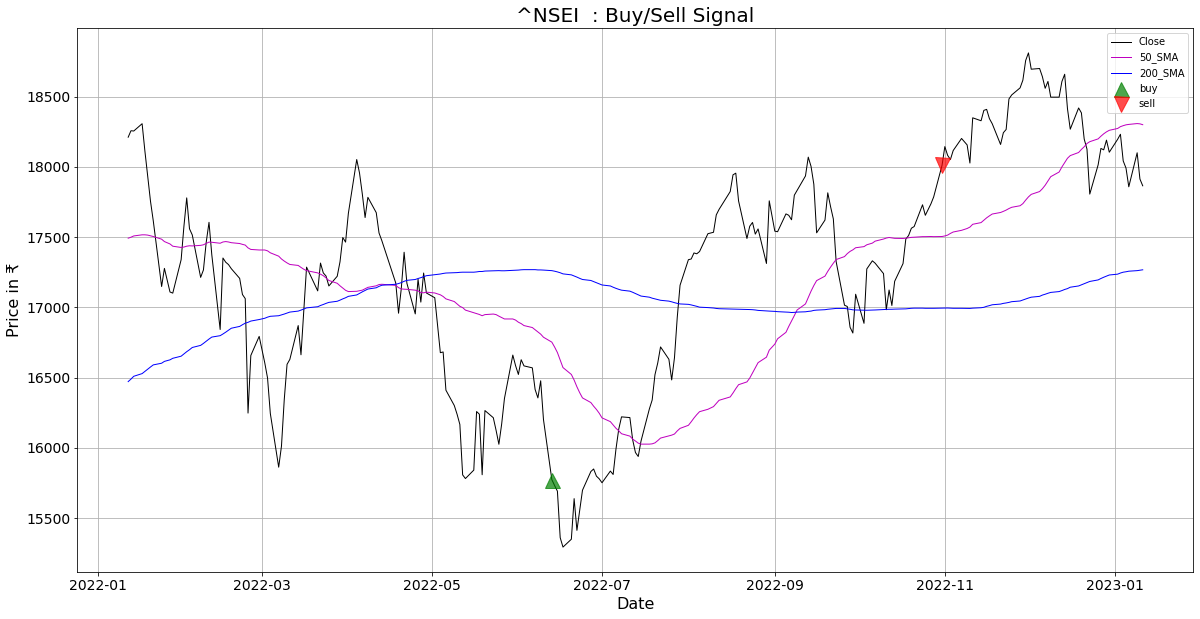

^NSEI
+------------+---------+----------+-----------+---------+------------+-------+-------+------------+-------------+-------+----------+------------+
| Date       |   Close |   50_SMA |   200_SMA | Stock   |   Dev%_200 |   Max |   Min |   Premium% |   Discount% |   RSI |   Signal | Position   |
|------------+---------+----------+-----------+---------+------------+-------+-------+------------+-------------+-------+----------+------------|
| 2022-06-13 |   15774 |    16753 |     17262 | ^NSEI   |      -8.62 | 18477 | 15632 |       5.01 |       94.99 |    35 |        1 | Buy        |
| 2022-10-31 |   18012 |    17505 |     16995 | ^NSEI   |       5.99 | 18308 | 15294 |      90.19 |        9.81 |    66 |       -1 | Sell       |
+------------+---------+----------+-----------+---------+------------+-------+-------+------------+-------------+-------+----------+------------+


In [ ]:
stock_symbol = '^NSEI'
df_prec_dev = get_stock_movements(stock_symbol, 365)

plot_stock_buy_sell(df_prec_dev)

In [ ]:
df_buy_sell = pd.DataFrame()

for stock_id in stock_ids:
    df_prec_dev = pd.DataFrame()
    stock_id = stock_id.upper() + '.NS'
    df_prec_dev = get_stock_movements(stock_id, 90)
    tmp = get_stock_buy_sell(df_prec_dev)
    df_buy_sell = df_buy_sell.append(tmp)
    
df_buy_sell.sort_index()

,Close,50_SMA,200_SMA,Stock,Dev%_200,Max,Min,Premium%,Discount%,RSI,Signal,Position
Date,,,,,,,,,,,,
2022-10-17,204.0,192.0,161.0,INDIANB.NS,26.99,207.0,127.0,96.81,3.19,58.0,-1.0,Sell
2022-10-18,340.0,325.0,269.0,ITC.NS,26.51,346.0,202.0,96.04,3.96,60.0,-1.0,Sell
2022-10-18,141.0,131.0,109.0,BANKBARODA.NS,29.04,142.0,77.0,97.92,2.08,61.0,-1.0,Sell
2022-10-20,702.0,751.0,822.0,MOTILALOFS.NS,-14.57,979.0,698.0,1.49,98.51,37.0,1.0,Buy
2022-10-20,1137.0,1068.0,985.0,CIPLA.NS,15.41,1145.0,856.0,97.16,2.84,65.0,-1.0,Sell
2022-10-20,259.0,235.0,219.0,CANBK.NS,18.22,261.0,175.0,97.56,2.44,67.0,-1.0,Sell
2022-10-20,270.0,289.0,305.0,NAM-INDIA.NS,-11.38,457.0,261.0,4.74,95.26,43.0,1.0,Buy
2022-10-21,70.0,76.0,94.0,NATIONALUM.NS,-25.80,130.0,67.0,4.37,95.63,44.0,1.0,Buy
2022-10-21,907.0,880.0,778.0,ICICIBANK.NS,16.60,918.0,650.0,95.95,4.05,60.0,-1.0,Sell


In [ ]:
df_buy_sell[df_buy_sell['Position'] == 'Buy'].sort_index().tail(20)

,Close,50_SMA,200_SMA,Stock,Dev%_200,Max,Min,Premium%,Discount%,RSI,Signal,Position
Date,,,,,,,,,,,,
2022-10-20,702.0,751.0,822.0,MOTILALOFS.NS,-14.57,979.0,698.0,1.49,98.51,37.0,1.0,Buy
2022-10-20,270.0,289.0,305.0,NAM-INDIA.NS,-11.38,457.0,261.0,4.74,95.26,43.0,1.0,Buy
2022-10-21,70.0,76.0,94.0,NATIONALUM.NS,-25.80,130.0,67.0,4.37,95.63,44.0,1.0,Buy
2022-11-03,861.0,921.0,1062.0,VOLTAS.NS,-18.90,1315.0,861.0,0.06,99.94,39.0,1.0,Buy
2022-11-03,388.0,400.0,478.0,WIPRO.NS,-18.72,714.0,375.0,3.98,96.02,47.0,1.0,Buy
2022-11-07,3415.0,3630.0,3917.0,DIVISLAB.NS,-12.83,4914.0,3415.0,-0.03,100.03,37.0,1.0,Buy
2022-11-10,415.0,445.0,476.0,GODREJIND.NS,-12.89,644.0,408.0,2.82,97.18,29.0,1.0,Buy
2022-11-25,452.0,512.0,520.0,ICICIPRULI.NS,-13.06,615.0,446.0,3.61,96.39,24.0,1.0,Buy
2022-12-23,378.0,417.0,428.0,TATAMOTORS.NS,-11.60,525.0,372.0,4.15,95.85,24.0,1.0,Buy


In [ ]:
df_buy_sell[df_buy_sell['Position'] == 'Sell'].sort_index().tail(20)

,Close,50_SMA,200_SMA,Stock,Dev%_200,Max,Min,Premium%,Discount%,RSI,Signal,Position
Date,,,,,,,,,,,,
2022-10-21,907.0,880.0,778.0,ICICIBANK.NS,16.60,918.0,650.0,95.95,4.05,60.0,-1.0,Sell
2022-10-24,570.0,540.0,500.0,SBIN.NS,14.10,574.0,434.0,97.50,2.50,63.0,-1.0,Sell
2022-10-24,802.0,763.0,715.0,BHARTIARTL.NS,12.18,809.0,638.0,95.96,4.04,63.0,-1.0,Sell
2022-10-25,3711.0,3509.0,2880.0,EICHERMOT.NS,28.84,3749.0,2241.0,97.46,2.54,62.0,-1.0,Sell
2022-10-27,1294.0,1271.0,1021.0,M&M.NS,26.75,1322.0,684.0,95.63,4.37,61.0,-1.0,Sell
2022-10-27,2704.0,2607.0,2408.0,TITAN.NS,12.28,2738.0,1929.0,95.77,4.23,60.0,-1.0,Sell
2022-10-28,9493.0,8883.0,8232.0,MARUTI.NS,15.31,9493.0,6725.0,99.98,0.02,71.0,-1.0,Sell
2022-10-31,2023.0,1910.0,1765.0,LT.NS,14.62,2043.0,1453.0,96.63,3.37,66.0,-1.0,Sell
2022-10-31,1017.0,924.0,884.0,SUNPHARMA.NS,15.03,1017.0,729.0,99.97,0.03,71.0,-1.0,Sell


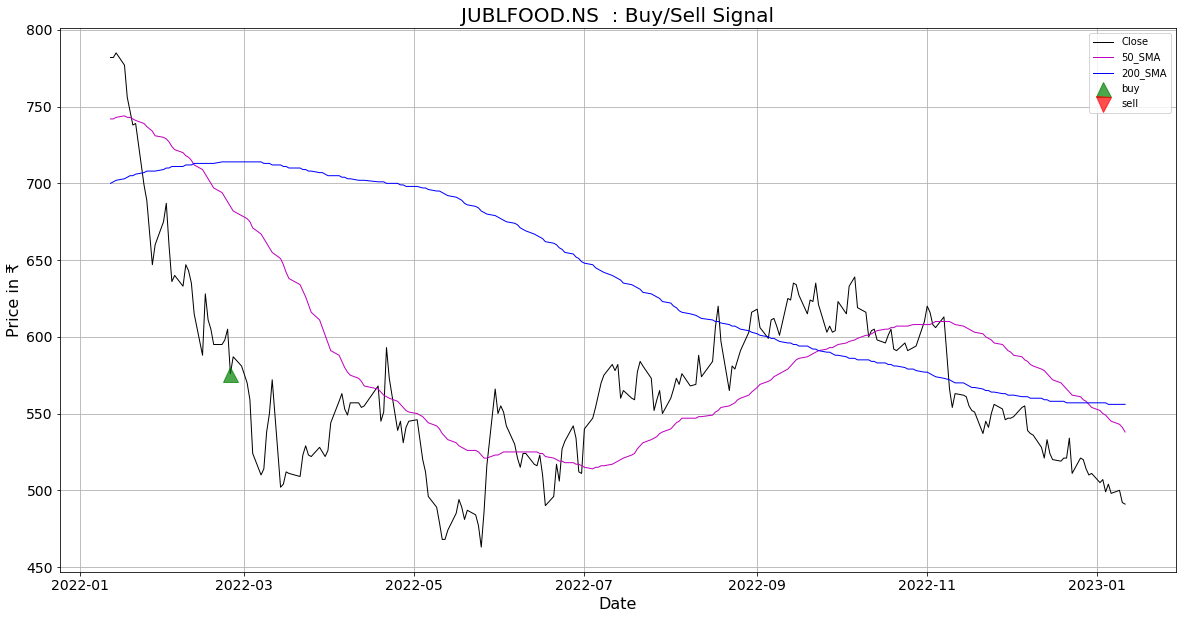

JUBLFOOD.NS
+------------+---------+----------+-----------+-------------+------------+-------+-------+------------+-------------+-------+----------+------------+
| Date       |   Close |   50_SMA |   200_SMA | Stock       |   Dev%_200 |   Max |   Min |   Premium% |   Discount% |   RSI |   Signal | Position   |
|------------+---------+----------+-----------+-------------+------------+-------+-------+------------+-------------+-------+----------+------------|
| 2022-02-24 |     576 |      685 |       714 | JUBLFOOD.NS |     -19.37 |   903 |   544 |       8.83 |       91.17 |    32 |        1 | Buy        |
+------------+---------+----------+-----------+-------------+------------+-------+-------+------------+-------------+-------+----------+------------+


In [ ]:
stock_symbol = 'JUBLFOOD.NS'
df_prec_dev = get_stock_movements(stock_symbol, 365)

plot_stock_buy_sell(df_prec_dev)